<a href="https://colab.research.google.com/github/KMayank29/Deep-Neural-Networks-CNN-/blob/master/read_numberplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT INTRODUCTION  

In this Notebook I have built a machine learning model that can read the number plate of a vehicle using state of the art computer vision algorithm **YOLO** i.e *you only look once* created by Joseph Redmon et al. YOLO has been originally written in C and CUDA but I have used its tensorflow implementation [darkflow](https://github.com/thtrieu/darkflow).     

The output of the YOLO model has been manipulated with a peice of codes written in Python language and from here the manipulated image has been passed to *tesseract* an optical character recognition (**OCR**) library that can read the characters on the numberplate.  

A critical obstacle for this project was to get *Region of Interest* (**RoI**) that is in our case was the number plate of the vehicle. As YOLO could detect eighty different classes but it can't detect a number plate. For this reason I have to train the model so that it could detect the objects of our interest.   

Here again comes an obstacle. Training a complex model like YOLO  from the scratch requires a lot data and multiple gpus and takes at least a week of time. To overcome this problem I have used the novel technique of **Transfer Learnng**. Machine Learning researchers define *transfer learning* as a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. It has been observed that if a  model has worked for a particular task in computer vision then it'd work for another task in the same domain.

I have downloaded pre-trained weights and model configuration from the original sites of the YOLO model [darknet](https://pjreddie.com/darknet/). The weights has been re-trained with my own labelled data using the gpu of Google Colab.  



## Data Preparation  


**Google Images:** I have downloaded images of Indian cars from google where the number plate was clearly visible in *.jpg* format. The next import important step was to annotate the images. I have used [labelImg](https://github.com/tzutalin/labelImg) for this purpose and saved the files as *.xml* in another folder with the same name as of the corresponding images.   

**This notebook broadly contains three sections:**    



1.   **Darkflow installation**
2.   **Model training**
2.   **Optical Character Recognition**





### Darkflow Installation

In [1]:
### CLONE DARKFLOW

! git clone https://github.com/KMayank29/darkflow.git

Cloning into 'darkflow'...
remote: Enumerating objects: 2713, done.
remote: Total 2713 (delta 0), reused 0 (delta 0), pack-reused 2713
Receiving objects: 100% (2713/2713), 18.74 MiB | 14.12 MiB/s, done.
Resolving deltas: 100% (1787/1787), done.


In [2]:
### INSTALL DARKFLOW

! pip install /content/darkflow

Processing ./darkflow
  Stored in directory: /tmp/pip-ephem-wheel-cache-2b6_f_pw/wheels/2f/3a/c5/e84e79d73d5a73aa1b5129a66a40947d9d77a32ebed501e431
Successfully built darkflow


### Configure the root directory:    

We need to place model configuration, the corresponding weights, images and annotations to the root directory of the notebook.  



1.   Upload everything to the google drive
2.   Mount the google drive to this notebook
1.  Copy all the relevant items to the root directory    

### Editing the .cfg file: 
The original model configuration file contains 80 classes but we need our model to train on just one class. Therefore we edit the number of classes from 80 to 1.  

We open the configuration file and go to **region section** and make the edit.  

Once the number of class has been changed the number of filter has to be changed too.  

The formula for filter is, **filter = anchor * (classes + 5)**.  As the number of anchor is fixed at 5, thus in our case the number of filter would be 30.  

### Editing labels.txt file  
This file contains the label of training classes. In our case the only class is number plate. So, I have edited the class with name of '**nplate**'




In [0]:
### COPY CINFIG, WEIGHTS etc. TO ROOT DIRECTORY

### MOUNT GOOGLE DRIVE

from google.colab import drive

drive.mount('gdrive')

In [0]:
# copy .cfg file to root directory
! cp -r '/content/gdrive/My Drive/cfg'  '/content/'

# copy yolo.weights to root directory
! cp -r '/content/gdrive/My Drive/Colab Notebooks/workspace/yolo.weights'  '/content/'

# copy annotations file to root directory
! cp -r '/content/gdrive/My Drive/Colab Notebooks/workspace/annotations' '/content/'

# copy images to root directory
! cp -r '/content/gdrive/My Drive/Colab Notebooks/workspace/images'  '/content/'

# copy labels.txt file to root directory  
! cp '/content/gdrive/My Drive/labels.txt' '/content/'

## Model Training  


**Recap**   
Till now we have labelled tha data, installed the darkflow and downloaded the weights and its configuration. We have also placed the relevant items to the root directory of this notebook.  

**Training**  
We can train the model in two ways by using


1.   **bash commands**
2.   **interactive programming**

I'll use interactive programming for this notebook but also mention the corresponding bash commands for each step.  


**Following are the important steps involved in training of the model:**   



1.   **Instantiate the class TFNet:**  In darkflow TFNet is the class with which different methods are associated like 'train', 'predict', etc.   

2.   **Train method:**  Once the class has been instantiated I  call train method and define their attributes which would train the model on my data. I set gpu = 1 means my model would train on gpu.    



*   **model:** We put the edited configuration file (.cfg) in the root directory  
*   **weights:** Model pre-trained weight is placed at the root directory
*   **annotation & dataset:** Similarly annotation and image files has been kept in the root directory in two different folders
*  **batch:** Set the batch size equals to 8. It is advised to keep the size of batch in multiple of 2.
*   **epoch:** I have set the epoch (number of training cycle) to 200
***









In [0]:
### IMPORT THE LIB

import matplotlib.pyplot as plt
import numpy as np

from darkflow.net.build import TFNet
import cv2

In [0]:
## ! flow --model /content/cfg/yolo_1c.cfg --load /content/yolo.weights --train --gpu 1.0

In [0]:
## Atributes related to train method

options = {"model": "./cfg/yolo_1c.cfg", 
           "load": "./yolo.weights",
           "batch": 8,
           "epoch": 100,
           "gpu": 1.0,
           "train": True,
           "annotation": "/content/annotations/",
           "dataset": "/content/images/"}

In [8]:
## call the TFNet class

tfnet = TFNet(options)

"""
similar bash commands

>> ! flow --model /content/cfg/yolo_1c.cfg --load /content/yolo.weights --train --gpu 1.0

"""

Parsing ./cfg/yolo.cfg
Parsing ./cfg/yolo_1c.cfg
Loading ./yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.023602962493896484s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
Instructions for updating:
Colocations handled automatically by placer.
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 7

'\nsimilar bash commands\n\n>> ! flow --model /content/cfg/yolo_1c.cfg --load /content/yolo.weights --train --gpu 1.0\n\n'

In [9]:
## Model training starts

tfnet.train()


./cfg/yolo_1c.cfg parsing /content/annotations/
Parsing for ['nplate'] 
[====================>]100%  19.xml
Statistics:
nplate: 71
Dataset size: 71
Dataset of 71 instance(s)
Training statistics: 
	Learning rate : 1e-05
	Batch size    : 8
	Epoch number  : 100
	Backup every  : 2000
step 1 - loss 225.67445373535156 - moving ave loss 225.67445373535156
step 2 - loss 223.0175018310547 - moving ave loss 225.40875854492188
step 3 - loss 221.85391235351562 - moving ave loss 225.05327392578127
step 4 - loss 219.62313842773438 - moving ave loss 224.5102603759766
step 5 - loss 218.7300567626953 - moving ave loss 223.9322400146485
step 6 - loss 217.323974609375 - moving ave loss 223.27141347412115
step 7 - loss 217.19625854492188 - moving ave loss 222.66389798120122
step 8 - loss 215.911865234375 - moving ave loss 221.9886947065186
Finish 1 epoch(es)
step 9 - loss 215.46527099609375 - moving ave loss 221.33635233547614
step 10 - loss 214.10800170898438 - moving ave loss 220.61351727282698
step 11

In [0]:
## save the trained weights

! cp -r '/content/ckpt' '/content/gdrive/My Drive/yolo_1c_2/'

! cp -r '/content/cfg'  '/content/gdrive/My Drive/yolo_1c_2/'

### Checkpoint   


During training of the model, darkflow creates a folder named *ckpt* in the root directory where the weights are being saved after certain number of steps of training.    

Once the training is completed all the updated weights are stored in the *ckpt* folder and we can call the *load* method of *TFNet* class to load the weights in the configuration and thus the model is ready to make predictions.   



In [0]:
options = {"model": "./cfg/yolo_1c.cfg",
           "load": -1,
           "gpu": 1.0}

In [13]:
tfnet2 = TFNet(options)

Parsing ./cfg/yolo_1c.cfg
Loading None ...
Finished in 0.00027561187744140625s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 76, 

In [14]:
tfnet2.load_from_ckpt()

Loading from ./ckpt/yolo_1c-800
INFO:tensorflow:Restoring parameters from ./ckpt/yolo_1c-800


### YOLO Model Output   

**Output:**  The output of the model is a list containing:  



*   **label name:** It is the name of the class for which the model has been trained for. In our case the label name is *nplate*
*   **confidence:**  It is the probability of the precence of the class in the input image.
*  **bounding box coordinates:** It contains the bounding box coordinates having upper left and bottom right vertices   


### Steps involved in making predictions  

**OpenCV:** We use openCV library to read the images. This converts the image into ndarray.   

**TFNet.return_predict** We call this method and feed it with ndarray image and get the above mentioned output.





In [36]:
## Upload a test image file

from google.colab import files

uploaded = files.upload()

Saving test5.jpg to test5.jpg


In [46]:
## MAKE PREDICTIONS

import pprint as pp


original_img = cv2.imread("/content/test.jpg")
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
results = tfnet2.return_predict(original_img)
print(results)

[{'label': 'nplate', 'confidence': 0.7696938, 'topleft': {'x': 373, 'y': 569}, 'bottomright': {'x': 645, 'y': 610}}]


### Plot Bounding Box   



*   **confidence threshold:** We put a certain threshold on the confidence level  output and select the list item having highest probability and also above the threshold 
*   **OpenCV:** We use this library to put rectangular box around the selected region of interest (**RoI**) and also the text mentioning the label name with probability.



In [0]:
## Function for putting rectangular box around the RoI


def boxing(original_img , predictions):
    newImage = np.copy(original_img)

    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label'] + " " + str(round(confidence, 3))
        
        if confidence > 0.50:
            newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 3)
            newImage = cv2.putText(newImage, label, (top_x, top_y-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.8, (0, 230, 0), 1, cv2.LINE_AA)
        
    return newImage

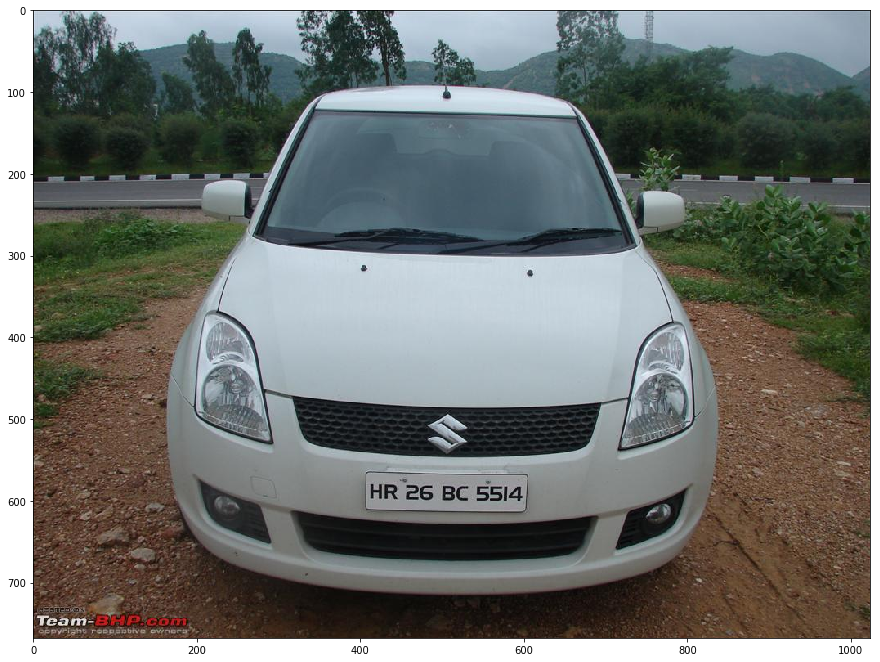

In [47]:
## Input test image

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(original_img)

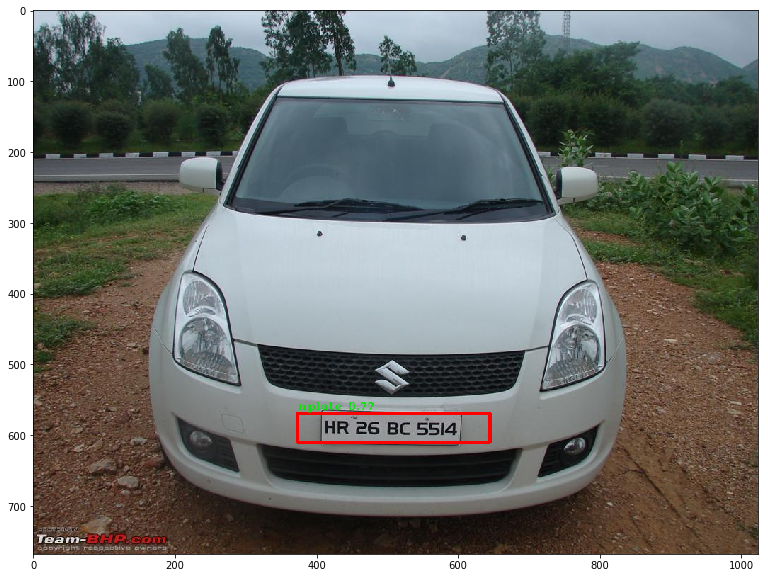

In [48]:
## Output 

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(boxing(original_img, results))

## Optical Character Recognition  

**Read the characters appearing in the Region of Interest**   



*   We crop the region of interest (**RoI**) bounded by the rectangular box and then this cropped image is passed into *tesseract* an OCR library.
*  Tesseract will give the text output



In [0]:
##  HELPER FUNCTION FOR CROPPING THE IMAGE

def croping(original_img , predictions):
  
    newImage = np.copy(original_img)

    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label'] + " " + str(round(confidence, 3))
        
        if confidence > 0.50:
            crop1_img = original_img[top_y : btm_y, top_x : btm_x]
            
    return crop1_img

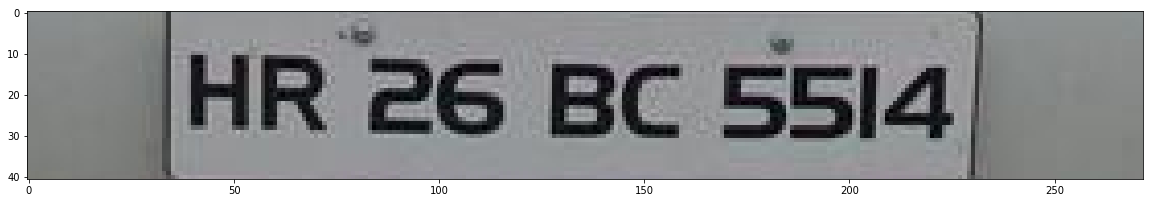

In [49]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(croping(original_img, results))

In [0]:
## insatling tesseract and pytesseract

! sudo apt install tesseract-ocr
! sudo apt install libtessarct-dev
! pip install pytesseract

In [0]:
## import the pytesseract module

import pytesseract as pyt

config = ('-l eng --oem 1 --psm 3')


In [0]:
## helper function to read the text in croped image

def get_text(img, results):
  
  img1 = croping(img, results)
  
  text = pyt.image_to_string(img1, config=config)
  
  
  
  return text

In [50]:
## Read the image

txt = get_text(original_img, results)

print(txt)

HR 26 BC 5514


In [0]:
## Helper function to read an image

def read_img(path):
  
  original_img = cv2.imread(path)
  original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
  return original_img

In [0]:
## Helper function to get model o/p

def pred(original_img):
  predictions = tfnet2.return_predict(original_img)
  return predictions

In [0]:
## COMBINE ALL THE HELPER FUNCTIONS INTO ONE SINGLE FUNCTION

def predict(path, config):
  
  original_img = read_img(path)
  
  predictions = pred(original_img)
  
  newImg = boxing(original_img, predictions)
  
  crop_img = croping(original_img, predictions)
  
  text = pyt.image_to_string(crop_img, config=config)
  
  return newImg, text

HR 26 BC 5514
------------------------------


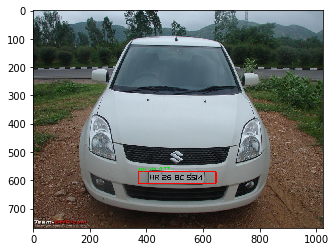

In [45]:
path = '/content/test.jpg'

test5, text5 = predict(path, config)

print(text5)
print('-'*30)
plt.imshow(test5)

## CONCLUSION   

The main aim of this project was to demonstrate that we can train our custom model using the technique of transfer learning and open source  library functions.   

In this note book I have shown the basic building blocks of a state of the art computer vision model that can be used to read not only number plates of a vehicle but can also read scaned documents, passports, driving license and many other similar things.